# **Preamble**

## Imports

In [186]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from collections import defaultdict, Counter
import pandas as pd
import subprocess 
import re
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score, mutual_info_score
import networkx as nx
import random
import copy
import statsmodels.api as sm
import pickle
from multiprocessing import Pool
from datetime import datetime as dt
from scipy import stats
from ulf import ulf

## Layout

In [29]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    fig_width_pt = 417.47*0.6
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    params = {
        'axes.labelsize': 10,
        'legend.fontsize': 7,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'STIXGeneral',  # close enough to LaTeX font
        'font.size': 8,
        'figure.frameon': False
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

# **Utility functions**

## General

In [30]:
def NMI_score(p1, p2, kind="adjusted"):
    """Takes two partitions in dict format and returns NMI of partition of common nodes."""
    nodes_inter = sorted(set(p1.keys()) & set(p2.keys()))
    nodes_union = sorted(set(p1.keys()) | set(p2.keys()))
    
    if len(nodes_inter) != len(nodes_union):
        print "Warning: len(nodes_inter) (%d) != len(nodes_union) (%d)" % (len(nodes_inter), len(nodes_union))
    
    if kind != "":
        kind += "_"
        
    return globals()[kind + 'mutual_info_score'](
        [p1[n] for n in nodes_inter],
        [p2[n] for n in nodes_inter]
    )

def get_cols(partition, randomize=False):
    cmap = ulf.cmap_in_range([min(partition.values()), max(partition.values())], cmap_style="hsv")
    cols = {}
    for commu in sorted(set(partition.values())):
        cols[commu] = cmap(commu)

    if randomize:
        cols = dict((k, v) for k, v in zip(cols.keys(), ulf.shuffle_list(cols.values())))

    return cols

def flatten_layer_partition(layer_partition, every_other=False):
    """Expand a layer-nested partition into a flat partition"""
    if every_other:
        layer_partition = dict(
            (k, v)
            for k, v in layer_partition.items()
            if k % gap == 0
        )
        
    return dict(
        (str(l) + "_" + str(n), c)  # ..., 0_1: 0, ...
        for l, partition in layer_partition.items()
        for c, nodes in partition.items()
        for n in nodes
    )

def inflate_layer_partition(flat_layer_partition):
    """Expand flat partition into layer-nested partition"""
    layer_partition = defaultdict(lambda: defaultdict(list))
    for l_n, c in flat_layer_partition.items():
        l, n = map(int, l_n.split("_"))
        layer_partition[l][c].append(n)
    return ulf.default_to_regular(layer_partition)

## Network

In [31]:
def generate_connected_graph(nodes):
    edges = set()
    for i1, n1 in enumerate(nodes):
        for i2, n2 in enumerate(nodes):
            if i2 > i1:
                edges.add((n1, n2))
    return edges

def compute_average_jssim(layer_partition, N):
    def _get_graph(l):
        G = nx.Graph()
        for c, nodes in layer_partition[l].items():
            G.add_edges_from(generate_connected_graph(nodes))
        return G

    jssims = []
    for l_i in sorted(layer_partition.keys()):
        for l_j in sorted(layer_partition.keys()):
            if l_i >= l_j: continue

            G_i = _get_graph(l_i)
            G_j = _get_graph(l_j)
            
            if set(G_i.edges()) == set(G_j.edges()):
                continue

            for n in range(N):
                p_i = np.array([1.0 if nn in G_i.neighbors(n) else 0.0 for nn in range(N)])
                p_i = p_i / sum(p_i)
                p_j = np.array([1.0 if nn in G_j.neighbors(n) else 0.0 for nn in range(N)])
                p_j = p_j / sum(p_j)
                jssims.append(1.0 - ulf.jsdiv(p_i, p_j))
    try:
        return np.mean(jssims), np.min(jssims), np.max(jssims)
    except ValueError:
        return 1.0, 1.0, 1.0

def compute_average_mutual_info(layer_partition, N):
    layer_pairs = []
    for l_i, c_nodes_i in sorted(layer_partition.items(), key=lambda (k, v): k):
        for l_j, c_nodes_j in sorted(layer_partition.items(), key=lambda (k, v): k):
            if l_i >= l_j or set(c_nodes_i.keys()) == set(c_nodes_j.keys()): continue
            layer_pairs.append((l_i, l_j))

    layer_labels = {}
    for l in set(ulf.unwrap(layer_pairs)):
        layer_labels[l] = ulf.invert_partition(layer_partition[l])

    mutual_info = []
    for l_i, l_j in layer_pairs:
        mutual_info.append(NMI_score(layer_labels[l_i], layer_labels[l_j], kind="normalized"))
    
    return np.mean(mutual_info), np.min(mutual_info), np.max(mutual_info)

def compute_average_mutual_info2(layer_partition, N):
    layer_pairs = []
    for l_i in sorted(layer_partition.keys()):
        for l_j in sorted(layer_partition.keys()):
            layer_pairs.append((l_i, l_j))

    partitions = {}
    for l in set(ulf.unwrap(layer_pairs)):
        partitions[l] = ulf.invert_partition(layer_partition[l])

    mutual_info = []
    for l_i, l_j in layer_pairs:
        mutual_info.append(NMI_score(partitions[l_i], partitions[l_j], kind="normalized"))
    
    return np.mean(mutual_info), np.min(mutual_info), np.max(mutual_info)

## Data

In [32]:
def load_binned_network(kind, filename):
    with open('data/processed_data/binned_networks/'+kind+'/'+filename+'.pkl', 'r') as infile:
        return pickle.load(infile)

# **Analysis**

## Get data

In [365]:
network_sensible = load_binned_network('1month_data_new','10mins_short_new'); fof = 2
network_workplace = pd.read_csv("data/workplace/tij_InVS.txt", delimiter=" ", names=["timestamp", 'user1', 'user2'])
network_workplace['timestamp'] = np.array([dt.fromtimestamp(ts) for ts in (network_workplace['timestamp'] + 86400 * 4)]) # Shift 4 days to make first day monday

In [132]:
## Sensible DTU data
## -----------------

## Make slices for a span of days (e.g. monday to friday)
# The below configuration gives exactly the first week of the three-week period in january 2014
spd = 288 / fof  # slices per day
smargin_start = 0 #spd / 3
smargin_end = 0 #spd / 3 - 6
dow = 0

# Correct to have empty layers where data is not used (similar to workplace)
network_sensible = [
    l[['user1', 'user2']]  # Set order of columns
    for d in range(0, 14)# + range(7, 12)# + range(14, 19)
    for l in network_sensible[spd*(dow+5+d)+smargin_start:spd*(dow+6+d)-smargin_end]
]

network_sensible = [
    df if 8 <= (l%144)/6. <= 17 else 
    pd.DataFrame(columns=['user1', 'user2'])
    for l, df in enumerate(network_sensible)
]


## Workplace data
## --------------

layer_size = 10 # Layer width in minutes

# Layer time bins from lower of first to (and including) upper of last
lower_bin = int(network_workplace['timestamp'].min().date().strftime("%s"))
upper_bin = int(network_workplace['timestamp'].max().date().strftime("%s")) + 86400
bins = [dt.fromtimestamp(ts) for ts in np.arange(lower_bin, upper_bin+layer_size*60, layer_size*60)]

# List of pandas dataframes, each a temporal network layer
network_workplace = [
    network_workplace[(network_workplace['timestamp'] > low) & (network_workplace['timestamp'] < high)] for low, high in zip(bins[:-1], bins[1:])
]

# Remove empty slices
network_workplace = [
    df_layer[['user1', 'user2']]
    for df_layer in network_workplace
    if len(df_layer) != 0
]

## Experiment 1

### Design

In [8]:
def create_edgelist(network_iter):
    edgelist = pd.DataFrame(columns=["node1", "node2", "layer"]).astype(int)
    for layer, df_layer in enumerate(network_iter):
        df_layer = copy.deepcopy(df_layer)
        df_layer.columns = ['node1', 'node2']
        df_layer['layer'] = layer
        edgelist = edgelist.append(df_layer)
    return edgelist

def compute_I_perfect(layer_communities, layer):
    def _node_comm_tuples(partition):
        return set(ulf.invert_partition(partition).items())
    
    # Get partitions in orig and copy layer as list of node-community tuples
    communities_orig = _node_comm_tuples(layer_communities[layer])
    communities_copy = _node_comm_tuples(layer_communities[max(layer_communities.keys())])
    
    # Intersection of two sets of tuples are perfect matches
    perfect_matches = set(communities_orig) & set(communities_copy)
    
    # Get perfect match community distribution
    community_distribution = dict(perfect_matches).values()
    
    # Get perfect match fraction and Shannon-entropy of perfect match community distribution
    p_perfect_matches = len(community_distribution) * 1.0 / len(communities_orig)
    H_perfect_matches = ulf.shannon_entropy(dict(perfect_matches).values())
    
    return [p_perfect_matches, H_perfect_matches, p_perfect_matches * H_perfect_matches]

def worker_NFC((pajek_iter, r, layer)):
    layer_communities = ulf.Infomap(
        pajek_iter,
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', str(r),
        '--overlapping',
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%s' % str(r)
    )[1]
    return r, compute_I_perfect(layer_communities, layer)

def worker_FC((pajek_iter, r, layer)):
    layer_communities = ulf.Infomap(
        pajek_iter,
        '-i',
        'multiplex',
        '--multiplex-relax-rate', str(r),
        '--overlapping',
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%s' % str(r)
    )[1]
    return r, compute_I_perfect(layer_communities, layer)

def worker_AC((pajek_iter, r, layer)):
    layer_communities = ulf.Infomap(
        pajek_iter,
        '-i',
        'multiplex',
        '--multiplex-relax-rate', str(r),
        '--multiplex-relax-limit', '1',
        '--overlapping',
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%s' % str(r)
    )[1]
    return r, compute_I_perfect(layer_communities, layer)

### Run

**Sensible DTU**

In [12]:
# p_perfect_r_NFC_sensible = defaultdict(list)
# p_perfect_r_FC_sensible = defaultdict(list)
# p_perfect_r_AC_sensible = defaultdict(list)
# H_perfect_r_NFC_sensible = defaultdict(list)
# H_perfect_r_FC_sensible = defaultdict(list)
# H_perfect_r_AC_sensible = defaultdict(list)
# I_perfect_r_NFC_sensible = defaultdict(list)
# I_perfect_r_FC_sensible = defaultdict(list)
# I_perfect_r_AC_sensible = defaultdict(list)

for layer, df_layer in enumerate(network_sensible):
    
    if layer < 120: continue
        
    # Create network
    print "Layer", layer
    
    print "    Creating network"
    network_sensible_iter = network_sensible + [network_sensible[layer]]
    print "    ... list of dataframes done."

    edgelist_sensible_iter = create_edgelist(network_sensible_iter)
    print "    ... edgelist done."

    pajek_sensible_iter = ulf.write_pajek(edgelist_sensible_iter)
    print "    ... pajek done."
    
    # Loop over varying relax rates
    r_vals = np.concatenate([
        np.array([0, 0.001]),
        np.linspace(0.01, 0.05, 5),
        np.linspace(0.1, 1, 17)
    ])
    
    print "    Starting processes",
    p = Pool(8)
    
    inputs = [(pajek_sensible_iter, r, layer) for r in r_vals]
        
    try:
        for r, [p_perfect, H_perfect, I_perfect] in p.map(worker_NFC, inputs):
            p_perfect_r_NFC_sensible[r].append(p_perfect)
            H_perfect_r_NFC_sensible[r].append(H_perfect)
            I_perfect_r_NFC_sensible[r].append(I_perfect)
        print "NFC done...",

        for r, [p_perfect, H_perfect, I_perfect] in p.map(worker_FC, inputs):
            p_perfect_r_FC_sensible[r].append(p_perfect)
            H_perfect_r_FC_sensible[r].append(H_perfect)
            I_perfect_r_FC_sensible[r].append(I_perfect)
        print "FC done...",

        for r, [p_perfect, H_perfect, I_perfect] in p.map(worker_AC, inputs):
            p_perfect_r_AC_sensible[r].append(p_perfect)
            H_perfect_r_AC_sensible[r].append(H_perfect)
            I_perfect_r_AC_sensible[r].append(I_perfect)
        print "AC done...",
    except KeyError:
        continue

    p.close()
    print "Done!"

Layer 0
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 1
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 2
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 3
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 4
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 5
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done..

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 16
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 17
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 18
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 19
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 20
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 21
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 22
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 31
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 32
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 33
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 34
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 35
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 36
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 39
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 40
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 41
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 42
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 43
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 44
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 45
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 46
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 47
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 53
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 54
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 55
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 56
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 57
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 58
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done

    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 102
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 103
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 104
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 105
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 106
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 107
    Creating network
    ... list 

KeyboardInterrupt: 

**Workplace** 

In [11]:
# p_perfect_r_NFC_workplace = defaultdict(list)
# p_perfect_r_FC_workplace = defaultdict(list)
# p_perfect_r_AC_workplace = defaultdict(list)
# H_perfect_r_NFC_workplace = defaultdict(list)
# H_perfect_r_FC_workplace = defaultdict(list)
# H_perfect_r_AC_workplace = defaultdict(list)
# I_perfect_r_NFC_workplace = defaultdict(list)
# I_perfect_r_FC_workplace = defaultdict(list)
# I_perfect_r_AC_workplace = defaultdict(list)

for layer, df_layer in enumerate(network_workplace):
    
    if layer < 34: continue
        
    # Create network
    print "Layer", layer
    
    print "    Creating network"
    network_workplace_iter = network_workplace + [network_workplace[layer]]
    print "    ... list of dataframes done."

    edgelist_workplace_iter = create_edgelist(network_workplace_iter)
    print "    ... edgelist done."

    pajek_workplace_iter = ulf.write_pajek(edgelist_workplace_iter)
    print "    ... pajek done."
    
    # Loop over varying relax rates
    r_vals = np.concatenate([
        np.array([0, 0.001]),
        np.linspace(0.01, 0.05, 5),
        np.linspace(0.1, 1, 17)
    ])
    print "    Starting processes",
    p = Pool(8)
    
    inputs = [(pajek_workplace_iter, r, layer) for r in r_vals]
    
    try:
        for r, [p_perfect, H_perfect, I_perfect] in p.map(worker_NFC, inputs):
            p_perfect_r_NFC_workplace[r].append(p_perfect)
            H_perfect_r_NFC_workplace[r].append(H_perfect)
            I_perfect_r_NFC_workplace[r].append(I_perfect)
        print "NFC done...",
        for r, [p_perfect, H_perfect, I_perfect] in p.map(worker_FC, inputs):
            p_perfect_r_FC_workplace[r].append(p_perfect)
            H_perfect_r_FC_workplace[r].append(H_perfect)
            I_perfect_r_FC_workplace[r].append(I_perfect)
        print "FC done...",
        for r, [p_perfect, H_perfect, I_perfect] in p.map(worker_AC, inputs):
            p_perfect_r_AC_workplace[r].append(p_perfect)
            H_perfect_r_AC_workplace[r].append(H_perfect)
            I_perfect_r_AC_workplace[r].append(I_perfect)
        print "AC done...",
    except KeyError:
        continue
    
    p.close()
    print "Done!"

 Layer 34
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 35
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 36
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 37
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 38
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 39
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 FC done... AC done... Done!
Layer 59
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 60
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 61
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 62
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 63
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 64
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting process

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 NFC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 FC done... AC done... Done!
Layer 80
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 81
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 82
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 83
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 84
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 85
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting process

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 FC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 107
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 108
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 109
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 AC done... Done!
Layer 110
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 111
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 112
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 113
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... Layer 114
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 115
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 NFC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 FC done... AC done... Done!
Layer 138
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done...

/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)
/usr/local/lib/python2.7/site-packages/ulf/ulf.py:661: RuntimeWarning: invalid value encountered in divide
  freq = np.array(counts) * 1.0 / np.sum(counts)


 Layer 139
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 140
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 141
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 142
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!
Layer 143
    Creating network
    ... list of dataframes done.
    ... edgelist done.
    ... pajek done.
    Starting processes NFC done... FC done... AC done... Done!


Process PoolWorker-1122:
Process PoolWorker-1121:
Process PoolWorker-1126:
Process PoolWorker-926:
Process PoolWorker-922:
Process PoolWorker-924:
Process PoolWorker-923:
Process PoolWorker-616:
Process PoolWorker-921:
Process PoolWorker-613:
Process PoolWorker-614:
Process PoolWorker-610:
Process PoolWorker-1123:
Process PoolWorker-1124:
Process PoolWorker-611:
Process PoolWorker-609:
Process PoolWorker-368:
Process PoolWorker-367:
Process PoolWorker-612:
Process PoolWorker-365:
Process PoolWorker-362:
Process PoolWorker-361:
Process PoolWorker-363:
Process PoolWorker-928:
Process PoolWorker-364:
Process PoolWorker-925:
Process PoolWorker-1125:
Process PoolWorker-1128:
Process PoolWorker-1127:
Process PoolWorker-927:
Process PoolWorker-615:
Process PoolWorker-366:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (mos

    self.run()
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/process.py", l

    task = get()
    task = get()
    task = get()
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    task = get()
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versions/2.7/lib/python2.7/multiprocessing/pool.py", line 102, in worker
  File "/usr/local/Cellar/python/2.7.13_1/Frameworks/Python.framework/Versi

### Result

**Sensible DTU**

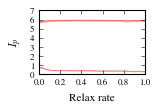

In [24]:
def compute_and_plot(perfect_r, color="#e74c3c"):
    x = sorted(perfect_r.keys())
    y = np.array([np.nanmean(perfect_r[r]) for r in x])
    err = np.array([np.nanstd(perfect_r[r]) / np.sqrt(len(perfect_r[r])) for r in x])
    plt.fill_between(x, y-err, y+err, color=color, lw=0, alpha=0.5)
    plt.plot(x, y, color="#e74c3c", lw=0.5)
    plt.xlabel("Relax rate")

plt.figure(figsize=(3.42/2, 2.0/2), frameon=False)
compute_and_plot(I_perfect_r_NFC_sensible)
compute_and_plot(I_perfect_r_AC_sensible)
plt.ylabel("$I_p$")
#plt.savefig("figures/choosing_r_NFC_I_sensible.pdf")

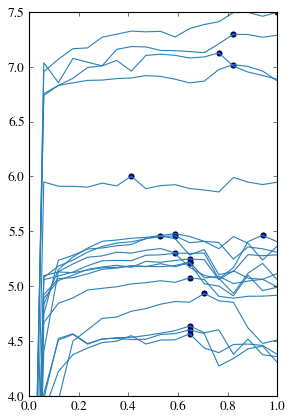

In [69]:
x = sorted(I_perfect_r_sensible.keys())

#cmap = ulf.cmap_in_range([-5, len(x)], cmap_style="Blues")
plt.figure(frameon=False, figsize=(4, 6))
for i in range(len(I_perfect_r_sensible.values()[0])):
    y = [I_perfect_r_sensible[x_][i] for x_ in x]
    x_, y_ = max(zip(x, y), key=lambda (x_, y_): y_)
    plt.plot(x, y, c="#2980b9")
    plt.scatter(x_, y_)
    
plt.xlim(0, 1)
plt.ylim(0, 8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(4, 7.5)
plt.show()

**Workplace**

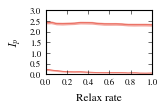

In [27]:
def compute_and_plot(perfect_r, color="#e74c3c"):
    x = sorted(perfect_r.keys())
    y = np.array([np.nanmean(perfect_r[r]) for r in x])
    err = np.array([np.nanstd(perfect_r[r]) / np.sqrt(len(perfect_r[r])) for r in x])
    plt.fill_between(x, y-err, y+err, color=color, lw=0, alpha=0.5)
    plt.plot(x, y, color="#e74c3c", lw=0.5)
    plt.xlabel("Relax rate")

plt.figure(figsize=(3.42/2, 2.0/2), frameon=False)
#compute_and_plot(I_perfect_r_NFC_workplace)
compute_and_plot(I_perfect_r_FC_workplace)
compute_and_plot(I_perfect_r_AC_workplace)
plt.ylabel("$I_p$")

#plt.savefig("figures/choosing_r_workplace.pdf")
plt.show()

## Experiment 2

### Design

In [258]:
def invert_layer_partition(layer_partition):
    return dict(
        ('%d_%d' % (layer, node), c)
        for layer, partition in layer_partition.items()
        for c, nodes in partition.items()
        for node in nodes
    )

def mutual_information_intersection(p1, p2, function=adjusted_mutual_info_score):
    """Take two partitions as dicts and returns MI of common nodes."""
    nodes = sorted(set(p1.keys()) & set(p2.keys()))
    if not (len(nodes) == len(p1) == len(p2)):
        raise Exception('Partitions do not have same nodes.')
    return function(
        [p1[n] for n in nodes],
        [p2[n] for n in nodes]
    )

def worker_NFC((pajek, r)):
    layer_communities = ulf.Infomap(
        pajek,
        '-i',
        'multiplex',
        '--multiplex-js-relax-rate', str(r),
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%s' % str(r)
    )[1]
    return r, invert_layer_partition(layer_communities)

def worker_FC((pajek, r)):
    layer_communities = ulf.Infomap(
        pajek,
        '-i',
        'multiplex',
        '--multiplex-relax-rate', str(r),
        '--expanded',
        '--clu',
        '-z',
        '--two-level',
        'pid%s' % str(r)
    )[1]
    return r, invert_layer_partition(layer_communities)

@ulf.keeptrying(Exception, verbose=True)
def test(worker, inputs, ref_r, process):
    output = []
    partition_ref = worker((inputs[0][0], ref_r))[1]
    for r, partition in process.map(worker, inputs):
        output.append(
            mutual_information_intersection(partition_ref, partition)
        )
    return output

### Run

**Workplace**

In [256]:
edgelist_workplace = create_edgelist(network_workplace)
pajek_workplace = ulf.write_pajek(edgelist_workplace)

# Loop over varying relax rates
r_vals = np.concatenate([
    np.linspace(0, 0.04, 4),
    np.linspace(0.05, 1, 20)
])

p = Pool(8)

inputs = [(pajek_workplace, r) for r in r_vals]
output_workplace_NFC = []
output_workplace_FC = []

for _ in range(10):
    output_workplace_NFC.append(test(worker_NFC, inputs, 0.25, p))
for _ in range(10):
    output_workplace_FC.append(test(worker_FC, inputs, 0.25, p))

p.close()
print "Done!"

Partitions do not have same nodes.
Done!


**Sensible DTU**

In [259]:
edgelist_sensible = create_edgelist(network_sensible)
pajek_sensible = ulf.write_pajek(edgelist_sensible)

# Loop over varying relax rates
r_vals = np.concatenate([
    np.linspace(0, 0.04, 4),
    np.linspace(0.05, 1, 20)
])

p = Pool(8)

inputs = [(pajek_sensible, r) for r in r_vals]
output_sensible_NFC = []
output_sensible_FC = []

for _ in range(10):
    output_sensible_NFC.append(test(worker_NFC, inputs, 0.25, p))
for _ in range(10):
    output_sensible_FC.append(test(worker_FC, inputs, 0.25, p))

p.close()
print "Done!"

Done!


### Result

**Workplace**

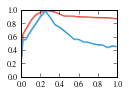

In [261]:
def mean_confidence_interval(data, confidence=0.95, axis=0):
    if axis == 0:
        a = 1.0 * np.array(data)
    elif axis == 1:
        a = 1.0 * np.array(data).T
    else:
        raise ValueError("axis must be equal to 0 or 1.")
    return stats.sem(a) * stats.t._ppf((1 + confidence) /2., len(a) - 1)

plt.figure(figsize=(3.42/2, 1.2), frameon=False)

plt.fill_between(
    r_vals,
    np.mean(output_workplace_NFC, axis=0) - mean_confidence_interval(output_workplace_NFC, axis=0),
    np.mean(output_workplace_NFC, axis=0) + mean_confidence_interval(output_workplace_NFC, axis=0),
    np.max(output_workplace_NFC, axis=0),
    color="#e74c3c", alpha=0.5
)
plt.plot(r_vals, np.mean(np.array(output_workplace_NFC), axis=0), label="NFC", color="#e74c3c")

plt.fill_between(
    r_vals,
    np.mean(output_workplace_FC, axis=0) - mean_confidence_interval(output_workplace_FC, axis=0),
    np.mean(output_workplace_FC, axis=0) + mean_confidence_interval(output_workplace_FC, axis=0),
    color="#3498db", alpha=0.5
)
plt.plot(r_vals, np.mean(np.array(output_workplace_FC), axis=0), label="FC", color="#3498db")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig("figures/r_stability_0.25_workplace.pdf")

**Sensible DTU**

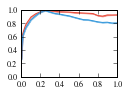

In [260]:
def mean_confidence_interval(data, confidence=0.95, axis=0):
    if axis == 0:
        a = 1.0 * np.array(data)
    elif axis == 1:
        a = 1.0 * np.array(data).T
    else:
        raise ValueError("axis must be equal to 0 or 1.")
    return stats.sem(a) * stats.t._ppf((1 + confidence) /2., len(a) - 1)

plt.figure(figsize=(3.42/2, 1.2), frameon=False)

plt.fill_between(
    r_vals,
    np.mean(output_sensible_NFC, axis=0) - mean_confidence_interval(output_sensible_NFC, axis=0),
    np.mean(output_sensible_NFC, axis=0) + mean_confidence_interval(output_sensible_NFC, axis=0),
    np.max(output_sensible_NFC, axis=0),
    color="#e74c3c", alpha=0.5
)
plt.plot(r_vals, np.mean(np.array(output_sensible_NFC), axis=0), label="NFC", color="#e74c3c")

plt.fill_between(
    r_vals,
    np.mean(output_sensible_FC, axis=0) - mean_confidence_interval(output_sensible_FC, axis=0),
    np.mean(output_sensible_FC, axis=0) + mean_confidence_interval(output_sensible_FC, axis=0),
    color="#3498db", alpha=0.5
)
plt.plot(r_vals, np.mean(np.array(output_sensible_FC), axis=0), label="FC", color="#3498db")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig("figures/r_stability_0.25_sensible.pdf")

# Me being lazy

In [445]:
network_sensible = load_binned_network('1month_data_new','10mins_short_new'); fof = 2
network_workplace = pd.read_csv("data/workplace/tij_InVS.txt", delimiter=" ", names=["timestamp", 'user1', 'user2'])
network_workplace['timestamp'] = np.array([dt.fromtimestamp(ts) for ts in (network_workplace['timestamp'] + 86400 * 4)]) # Shift 4 days to make first day monday

## Sensible DTU data
## -----------------

## Make slices for a span of days (e.g. monday to friday)
# The below configuration gives exactly the first week of the three-week period in january 2014
spd = 288 / fof  # slices per day
smargin_start = 0 #spd / 3
smargin_end = 0 #spd / 3 - 6
dow = 0

# Correct to have empty layers where data is not used (similar to workplace)
network_sensible = [
    l[['user1', 'user2']]  # Set order of columns
    for d in range(0, 5) + range(7, 12)# + range(14, 19)
    for l in network_sensible[spd*(dow+5+d)+smargin_start:spd*(dow+6+d)-smargin_end]
]

network_sensible = [
    df if 8 <= (l%144)/6. < 18 else 
    pd.DataFrame(columns=['user1', 'user2'])
    for l, df in enumerate(network_sensible)
]

## Workplace data
## --------------

layer_size = 10 # Layer width in minutes

# Layer time bins from lower of first to (and including) upper of last
lower_bin = int(network_workplace['timestamp'].min().date().strftime("%s"))
upper_bin = int(network_workplace['timestamp'].max().date().strftime("%s")) + 86400
bins = [dt.fromtimestamp(ts) for ts in np.arange(lower_bin, upper_bin+layer_size*60, layer_size*60)]

# List of pandas dataframes, each a temporal network layer
network_workplace = [
    network_workplace[(network_workplace['timestamp'] > low) & (network_workplace['timestamp'] < high)] for low, high in zip(bins[:-1], bins[1:])
]

# Remove empty slices
network_workplace = [
    df_layer[['user1', 'user2']]
    for df_layer in network_workplace
    if len(df_layer) != 0
]

In [446]:
edgelist_sensible = create_edgelist([df for df in network_sensible if len(df) > 0])
pajek_sensible = ulf.write_pajek(edgelist_sensible)

In [447]:
edgelist_workplace = create_edgelist([df for df in network_workplace if len(df) > 0])
pajek_workplace = ulf.write_pajek(edgelist_workplace)

In [ ]:
tmp = ulf.Infomap(
    pajek_workplace,
    '-i',
    'multiplex',
    '--multiplex-js-relax-rate', str(0.25),
#    '--multiplex-relax-limit', '1',
    '--expanded',
    '--clu',
    '-z',
    '--two-level'
)[1]

In [480]:
# sensible S empirical
nl_FC_uni = 71182705 - 126787
nl_NFC_uni = 48422591 - 126787
nl_AC_uni = 488126 - 126787

S_NFC_observed_uni = nl_NFC_uni * 1.0 / nl_FC_uni
S_AC_observed_uni = nl_AC_uni * 1.0 / nl_FC_uni

print "$S_{NFC}=$", S_NFC_observed_uni
print "$S_{AC}=$", S_AC_observed_uni

$S_{NFC}=$ 0.67968728516
$S_{AC}=$ 0.00508527664086


In [481]:
# workplace S empirical
nl_FC_wor = 436148 - 2908
nl_NFC_wor = 132349 - 2908
nl_AC_wor = 8129 - 2908

S_NFC_observed_wor = nl_NFC_wor * 1.0 / nl_FC_wor
S_AC_observed_wor = nl_AC_wor * 1.0 / nl_FC_wor

print "$S_{NFC}=$", S_NFC_observed_wor
print "$S_{AC}=$", S_AC_observed_wor

$S_{NFC}=$ 0.298774351399
$S_{AC}=$ 0.0120510571508


In [486]:
# <k> for sensible
num_links_uni = len(set([tuple(sorted(tuple(l)[:2]) + [l[2]]) for l in edgelist_sensible.values]))
num_nodes_uni = len(set(edgelist_sensible['node1']) | set(edgelist_sensible['node2']))
num_layers_uni = len(set(edgelist_sensible.layer))
k_average_uni = num_links_uni * 2. / (num_nodes_uni * num_layers_uni)

print "n  ", num_nodes_uni
print "e  ", num_links_uni
print "t  ", num_layers_uni
print "<k>", k_average_uni

 n   636
e   126787
t   600
<k> 0.664502096436


In [487]:
# <k> for workplace
num_links_wor = len(set([tuple(sorted(tuple(l)[:2]) + [l[2]]) for l in edgelist_workplace.values]))
num_nodes_wor = len(set(edgelist_workplace['node1']) | set(edgelist_workplace['node2']))
num_layers_wor = len(set(edgelist_workplace.layer))
k_average_wor = num_links_wor * 2. / (num_nodes_wor * num_layers_wor)

print "n  ", num_nodes_wor
print "e  ", num_links_wor
print "t  ", num_layers_wor
print "<k>", k_average_wor

n   92
e   2908
t   575
<k> 0.109943289225


In [488]:
def S_NFC(k, n):
    return 1. - np.exp(-k**2. / n)

def S_AC(t):
    return 2./t

print "University"
print "    effect NFC", S_NFC_observed_uni / S_NFC(k_average_uni, num_nodes_uni)
print "    effect NFC", 0.00508527664086 / S_AC(num_layers_uni)
print
print "Workplace"
print "    effect NFC", 0.67968728516 / S_NFC(k_average_wor, num_nodes_wor)
print "    effect NFC", 0.00508527664086 / S_AC(num_layers_wor)

University
    effect NFC 979.319276518
    effect NFC 1.52558299226

Workplace
    effect NFC 5173.5428589
    effect NFC 1.46201703425


In [305]:
len(set(edgelist_sensible['node1']) | set(edgelist_sensible['node2']))

645

In [319]:
len(set(edgelist_workplace['node1']) | set(edgelist_workplace['node2']))

85

In [388]:
edgelist_workplace

,node1,node2,layer
0,492,938,0
1,267,272,0
2,181,826,0
3,79,181,1
5,21,150,2
6,21,205,2
7,21,150,2
8,448,826,2
9,765,826,2
10,39,253,2
